In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os, glob
import pandas as pd
import numpy as np
import pickle

from matplotlib import ticker, cm, colors
from matplotlib.lines import Line2D
import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import griddata as scipyGrid

from NNMFit.utilities import ScanHandler

# import plotting utils
sys.path.append( "/data/user/tvaneede/utils" )
from FlavourScansPlotting import get_contour_points, plot_confidence_intervals

In [3]:
# load and set matplotlib parameters
%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager as font_manager
rcParams = {"axes.titlesize": 16,"axes.labelsize": 14,"xtick.labelsize": 14,"ytick.labelsize": 14}
mpl.rcParams.update(rcParams)
font_axis_label = {'family': 'serif','color':  'black','weight': 'normal','size': 22}
font_title = {'family': 'serif','color':  'black','weight': 'bold','size': 20}
font_legend = font_manager.FontProperties(family='serif',weight='normal',style='normal', size=13)

In [4]:
# import scanning points
from flavor_fracs import *
points = pd.read_pickle('/data/user/tvaneede/GlobalFit/custom_scan_flavor/default_custom_scan_points_flavor.pickle')
flavs = flavor_frac(np.asarray(points['astro_nue_ratio']),np.asarray(points['astro_nutau_ratio']))

In [5]:
# triangle plotting settings
from Ternary import flavor_triangle
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams.update({'font.family':'serif'})

In [6]:
plotting_path = "/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/notebooks/presentations/2026-02-04_diffuse_update"
os.system(f"mkdir -p {plotting_path}")

0

In [7]:
flavor_globalfit_path = "/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/dag_scans/flavor_globalfit/hese"

scan_dir_dict = {
"Spice old PID"        : f"{flavor_globalfit_path}/asimov_SAY_HESEBestfit_NoSystematics_spice",
"FTP old PID"        : f"{flavor_globalfit_path}/asimov_SAY_HESEBestfit_NoSystematics_ftp_FinalTopology",

"With syst."        : f"{flavor_globalfit_path}/asimov_SAY_HESEBestfit_ftp_FinalTopology",

"11 features purity"        : f"{flavor_globalfit_path}/mcd-flavor_flux-hese_feat-11features/bdt1_0.21_bdt2_0.55_length_10",
"11 features"        : f"{flavor_globalfit_path}/mcd-flavor_flux-hese_feat-11features/bdt1_0.366667_bdt2_0.433333_length_10",
"11 features, topology"        : f"{flavor_globalfit_path}/mcd-simpletopology_flux-hese_feat-11features/bdt1_0.366667_bdt2_0.433333_length_10",

"more features"        : f"{flavor_globalfit_path}/mcd-simpletopology_flux-hese_feat-11features_plus_rloglmilli_econf_evtgen/bdt1_0.4_bdt2_0.45_length_10",
"more features, new binning"        : f"{flavor_globalfit_path}/mcd-simpletopology_flux-hese_feat-11features_plus_rloglmilli_econf_evtgen/bdt1_0.3_bdt2_0.4_length_10_10bdtprod_threshold_0.12",

}

In [8]:
drop_unsuccessful = False
scan_dict = {}
for name, scan_dir in scan_dir_dict.items():
    print(name)
    scan_dict[name] = ScanHandler(scan_dir,dump=False,drop_unsuccessful=drop_unsuccessful)

Spice old PID
FTP old PID
With syst.
11 features purity
11 features
11 features, topology
more features
more features, new binning


In [31]:
data = {}
for name in scan_dict:
    # print(name)
    data[name] = {}
    data[name]["ftau_asimov_poisson"],data[name]["fe_asimov_poisson"],data[name]["ft_grid_asimov_poisson"],data[name]["fe_grid_asimov_poisson"],data[name]["ts_grid_asimov_poisson"] = get_contour_points(scan_dict,name)

removed stuff
removed stuff
removed stuff
removed stuff
removed stuff
removed stuff
removed stuff
removed stuff


In [10]:
ts_dict = {
    '68%' : 2.37,
    '90%' : 4.605,
    '95%' : 5.99,
}

In [11]:
colours = ["black","C0","C3","C2", "C1", "C4", "C5", "C6", "C7", "C8", "C9", "C10", "C11"]
linestyles = ["-","--",":"]

In [12]:
# needed for area comparison!
C = {}

def compare_contours( names, labels, levels = ['68%'], title = r"HESE: $\phi_0 = 2.12,\gamma=2.87$",output_name = "test" ):

    fig = plt.figure()
    tax = flavor_triangle()

    lh, ll = [], []

    asimov = tax.ca.scatter([1.0/3], [1.0/3], marker='*', facecolor='black',
                    edgecolor='k', lw=0.5, s=80)
    lh.append(asimov)
    ll.append('Asimov: 1:1:1')

    fmt={} # set labels to the contours

    ts_values = [ts_dict[i] for i in levels]

    for i,name in enumerate(names):
        C[name] = tax.ca.contour(data[name]["ft_grid_asimov_poisson"],
                                data[name]["fe_grid_asimov_poisson"],
                                data[name]["ts_grid_asimov_poisson"], 
                                ts_values,
                                linestyles=linestyles[:len(levels)],
                                linewidths=1.5,
                                colors=colours[i])
        
        h, _ = C[name].legend_elements()
        lh.append(h[0]) # legend elements
        ll.append(labels[i])

        # add ts levels in plot
        if i == len(names) - 1:
            for l, s in zip(C[name].levels, levels):
                fmt[l] = s
            plt.clabel(C[name],ts_values,inline=True,fontsize=12.,
                    fmt=fmt,colors='black')

    l = fig.legend(lh,ll,
                    bbox_to_anchor=(0.7, 0.05),prop=font_legend,
                    ncols=1 if len(names) < 5 else 2,frameon=True,fancybox=True,shadow=True)
    if title: plt.title(title,y=1.1,fontdict=font_title)    

    plt.savefig(f"{plotting_path}/contour_{output_name}.pdf",bbox_inches='tight')

In [13]:
def polygon_area(x, y):
    # Close path if not already closed
    if x[0] != x[-1] or y[0] != y[-1]:
        x = np.append(x, x[0])
        y = np.append(y, y[0])
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def compare_area( alt_key, base_key, levels ):
    areas = {}

    ts_values = [ts_dict[i] for i in levels]

    for name in [alt_key,base_key]: 
        # print(f"Processing {name}")
        contour_obj = C[name]
        area_list = []
        for i, level in enumerate(levels):  # 68%, 90%
            paths = contour_obj.collections[i].get_paths()
            level_area = 0.0
            for p in paths:
                v = p.vertices
                x, y = v[:, 0], v[:, 1]
                level_area += polygon_area(x, y)
            area_list.append(level_area)
            # print(f"Area for level {ts_values[i]} ({level}): {level_area:.4f}")
        areas[name] = area_list

    # Now calculate and print ratio of areas at 68% CL (index 0) and 90% CL (index 1)
    for i, level in enumerate(levels):
        ratio = areas[alt_key][i] / areas[base_key][i]
        print(f"Area ratio ({alt_key} / {base_key}) at {level}: {ratio:.4f}")

Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000


/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()


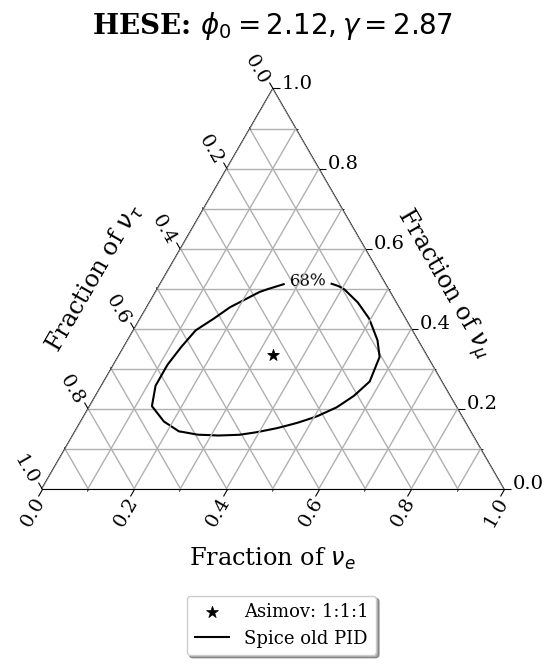

In [19]:
names = [
"Spice old PID",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "spice")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)


Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000
Area ratio (FTP old PID / Spice old PID) at 68%: 0.7598


/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()


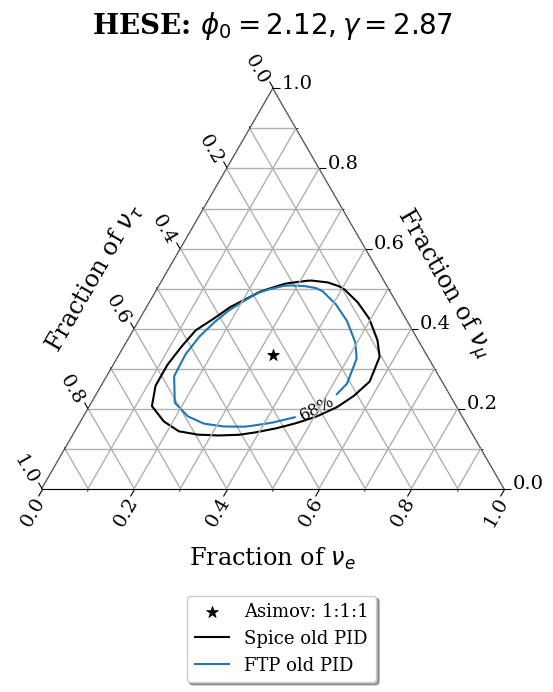

In [21]:
names = [
"Spice old PID",
'FTP old PID',
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "spice_ft_old_pid")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].g

Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000
Area ratio (FTP old PID / Spice old PID) at 68%: 0.7632
Area ratio (With syst. / Spice old PID) at 68%: 0.7444


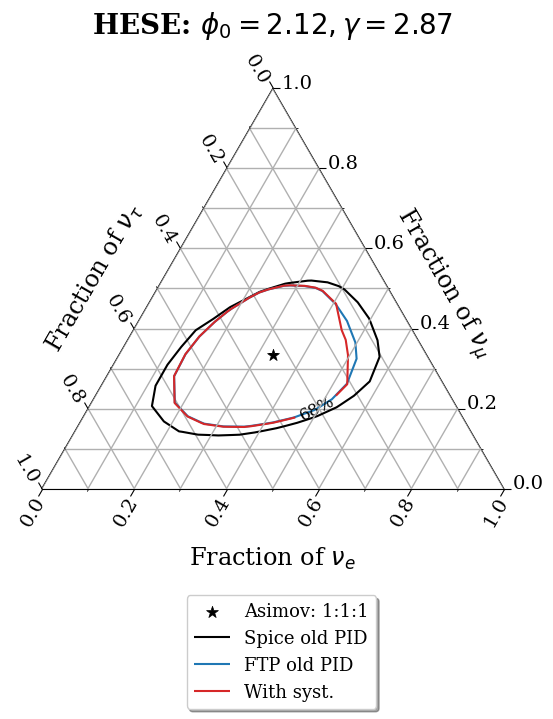

In [32]:
names = [
"Spice old PID",
'FTP old PID',
'With syst.',
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "spice_ft_old_pid_with_syst")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_1700106/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].g

Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000
Area ratio (FTP old PID / Spice old PID) at 68%: 0.7632
Area ratio (11 features purity / Spice old PID) at 68%: 0.6301
Area ratio (11 features / Spice old PID) at 68%: 0.6089


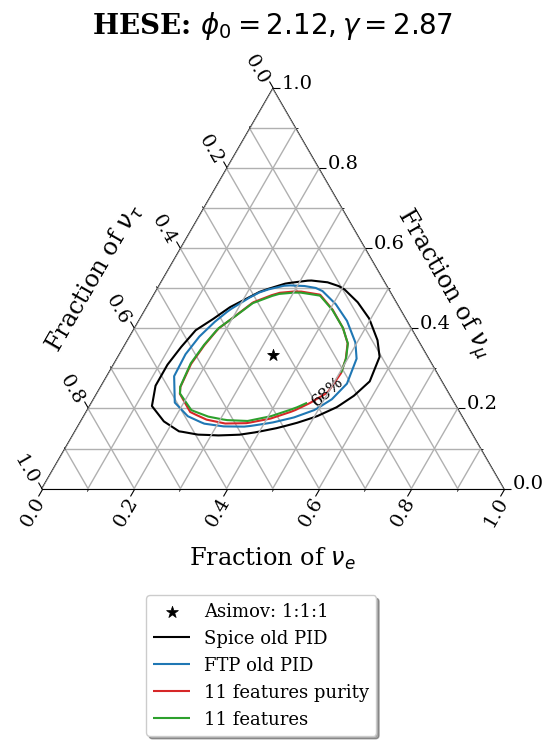

In [19]:
names = [
"Spice old PID",
'FTP old PID',
"11 features purity",
"11 features",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "spice_ftp_old_pid_11features_purity_fisher")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_p

Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000
Area ratio (FTP old PID / Spice old PID) at 68%: 0.7632
Area ratio (11 features / Spice old PID) at 68%: 0.6089


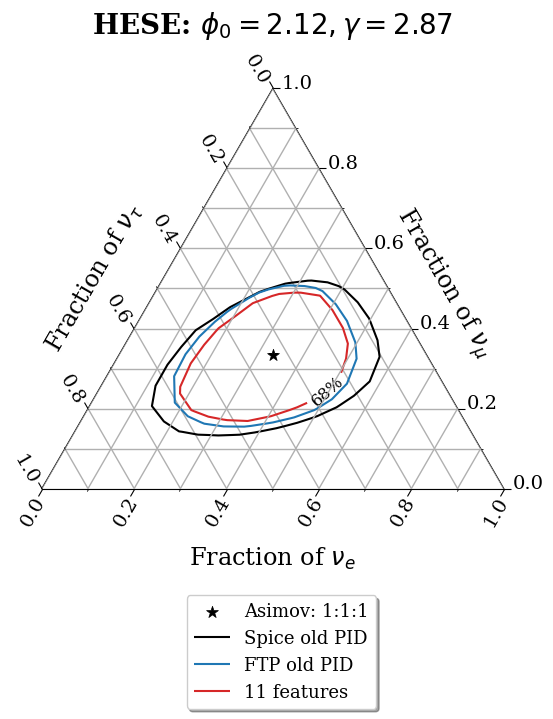

In [22]:
names = [
"Spice old PID",
'FTP old PID',
"11 features",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "spice_ftp_old_pid_11features")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_p

Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000
Area ratio (FTP old PID / Spice old PID) at 68%: 0.7632
Area ratio (11 features / Spice old PID) at 68%: 0.6138
Area ratio (more features / Spice old PID) at 68%: 0.5900


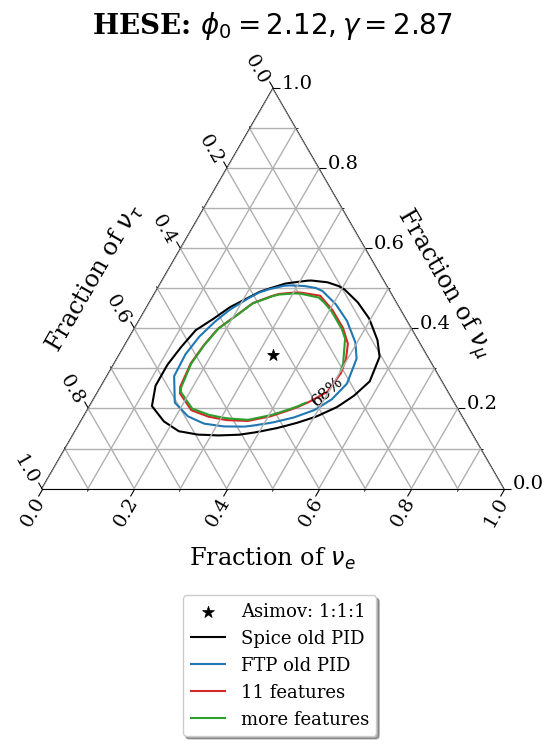

In [23]:
names = [
"Spice old PID",
'FTP old PID',
"11 features",
"more features",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "spice_ftp_old_pid_11features_allfeatures")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000
Area ratio (FTP old PID / Spice old PID) at 68%: 0.7632
Area ratio (11 features / Spice old PID) at 68%: 0.6138
Area ratio (11 features, topology / Spice old PID) at 68%: 0.6178
Area ratio (more features / Spice old PID) at 68%: 0.5951
Area ratio (more features, new binning / Spice old PID) at 68%: 0.5785


/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_o

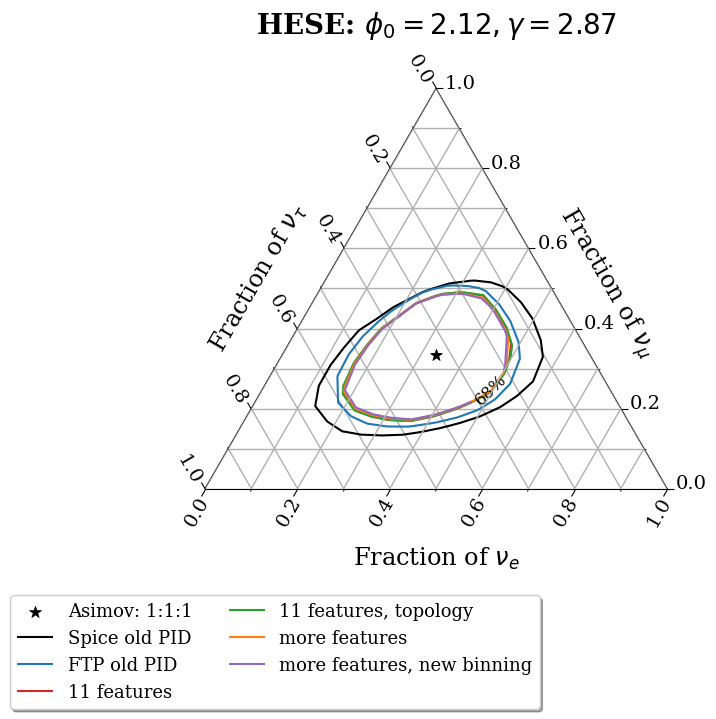

In [28]:
names = [
"Spice old PID",
'FTP old PID',
"11 features",
"11 features, topology",
"more features",
"more features, new binning",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "spice_ftp_old_pid_bdt_new_binning")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

/data/user/tvaneede/utils/Ternary.py:74: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.xaxis.grid(*args, **kwargs)


Area ratio (Spice old PID / Spice old PID) at 68%: 1.0000
Area ratio (FTP old PID / Spice old PID) at 68%: 0.7632
Area ratio (11 features / Spice old PID) at 68%: 0.6138
Area ratio (11 features, topology / Spice old PID) at 68%: 0.6178
Area ratio (more features / Spice old PID) at 68%: 0.5951
Area ratio (more features, new binning / Spice old PID) at 68%: 0.5785


/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_obj.collections[i].get_paths()
/tmp/ipykernel_594273/558599319.py:18: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour_o

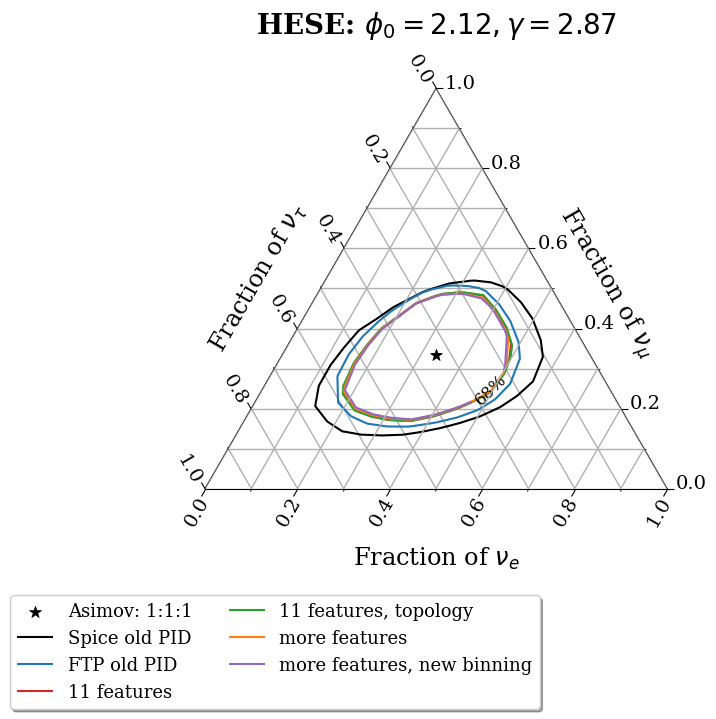

In [20]:
names = [
"Spice old PID",
'FTP old PID',
"11 features",
"11 features, topology",
"more features",
"more features, new binning",
]
labels = names
compare_contours( names = names,
                  labels = labels,
                  levels = ["68%"],
                  output_name = "all")

for name in names: compare_area( alt_key=name, base_key="Spice old PID", levels=["68%"] )

Lets plot some expected rates

In [ ]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/notebooks")
from plot_utils import *

In [ ]:
from NNMFit.utilities.readout_graphs import HistogramGraph
from NNMFit.core.analysis_config import AnalysisConfig


In [61]:
configs_dir = "/data/user/tvaneede/GlobalFit/reco_processing/NNMFit/configs/flavor_globalfit/"
config_hdl = AnalysisConfig.from_configs(
        main_config_file=f"{configs_dir}/main.cfg",
        analysis_config_file = f"{configs_dir}/analysis_configs/asimov/SAY/asimov_SAY_HESEBestfit.yaml",
        config_dir=configs_dir,
        override_dict=None,
        override_config_files=["override/systematics/NoSystematics.cfg", "override/datasets_hese/mcd-simpletopology_flux-hese_feat-11features_plus_rloglmilli_econf_evtgen/bdt1_0.4_bdt2_0.45_length_10.cfg"],
        override_components_files=None,
        override_parameters_files=None)

In [62]:
# build a histogram
hist_graph_hdl = HistogramGraph(config_hdl)
detector_configs = config_hdl.get_det_configs()

In [63]:
plotting_path_histogram = f"{plotting_path}/11features_plus_rloglmilli_econf_evtgen/bdt1_0.4_bdt2_0.45_length_10"
os.system(f"mkdir -p {plotting_path_histogram}")

0

IC86_pass2_SnowStorm_FTP_HESE_Cascades


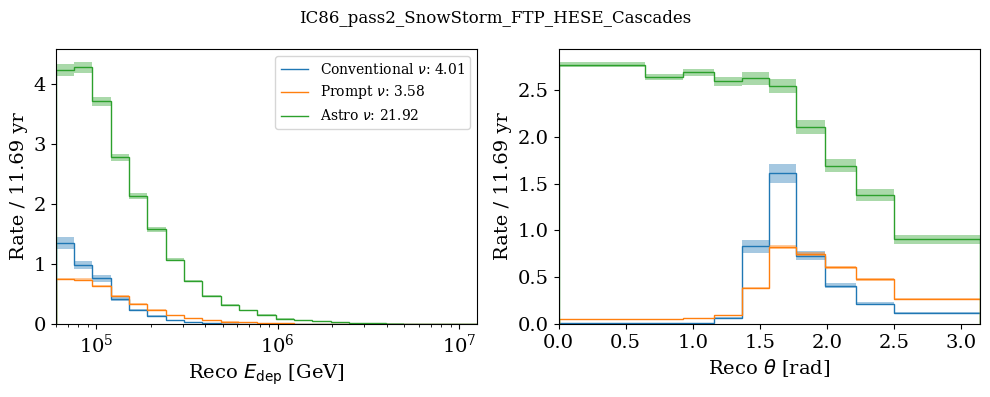

IC86_pass2_SnowStorm_FTP_HESE_Cascades


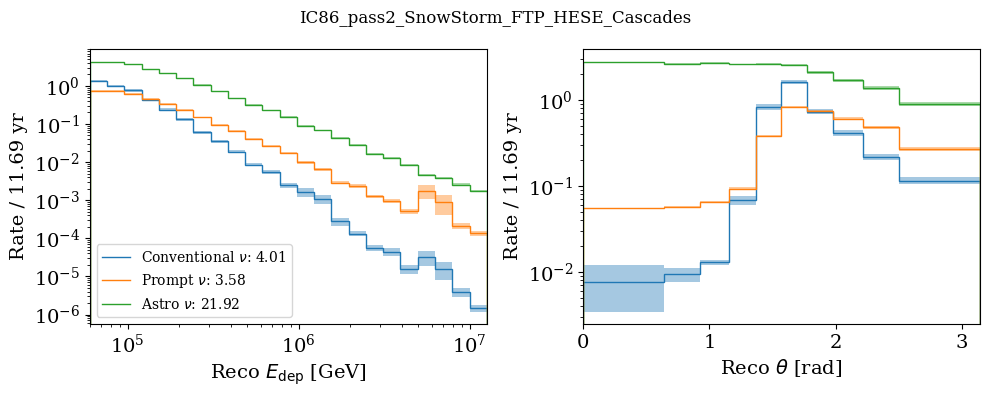

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


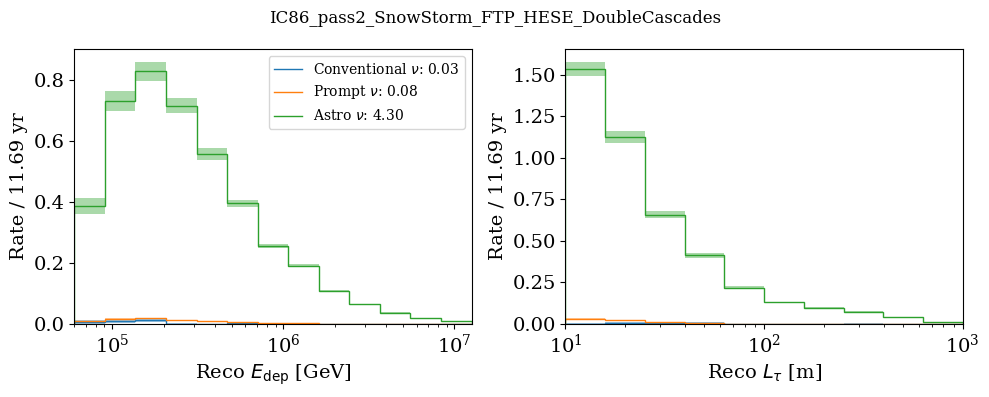

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


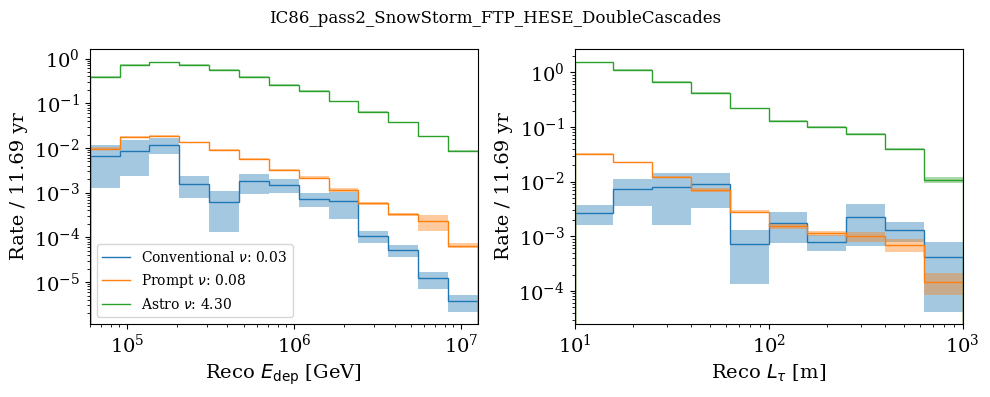

IC86_pass2_SnowStorm_FTP_HESE_Tracks


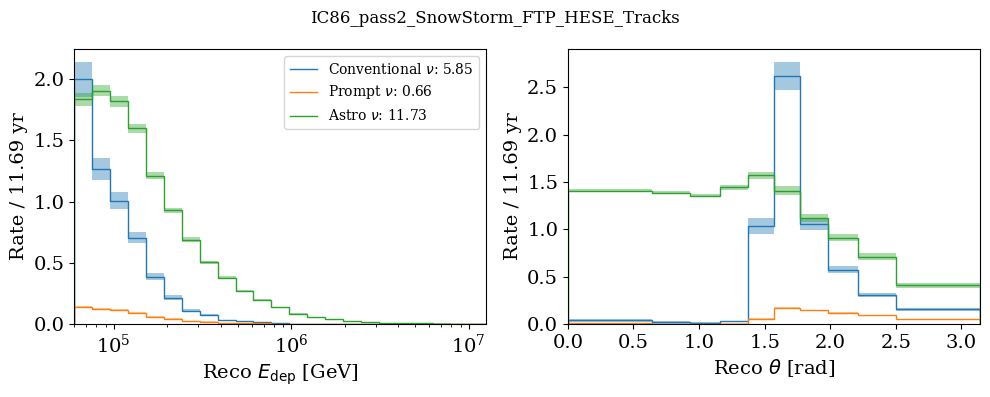

IC86_pass2_SnowStorm_FTP_HESE_Tracks


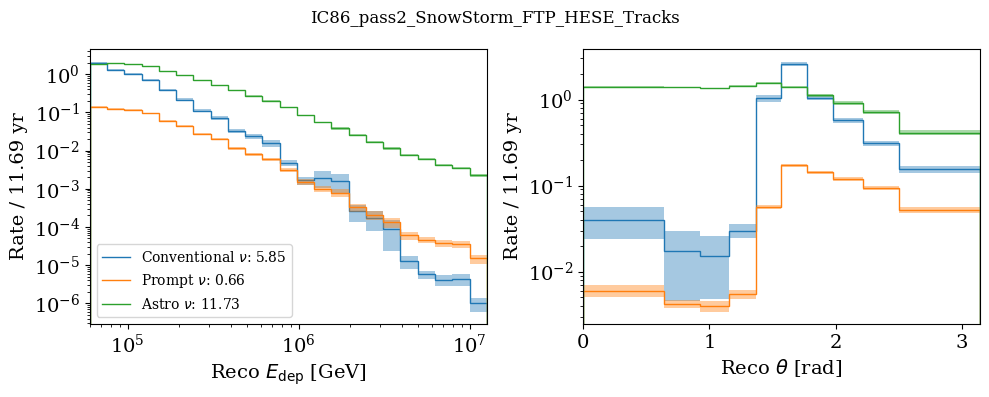

In [68]:
input_variables = {
    r"Conventional $\nu$" : {"astro_norm" : 0, "prompt_norm" : 0, "conv_norm" : 1},
    r"Prompt $\nu$" : {"astro_norm" : 0, "prompt_norm" : 1, "conv_norm" : 0},
    r"Astro $\nu$" : {"astro_norm" : 2.1233, "prompt_norm" : 0, "conv_norm" : 0},
}
for det_config in detector_configs: 
    plot_histogram(hist_graph_hdl=hist_graph_hdl, det_config=det_config, input_variables = input_variables, ylog=None, 
                   savepath=f"{plotting_path_histogram}/{det_config}_ylog-None.png")
    plot_histogram(hist_graph_hdl=hist_graph_hdl, det_config=det_config, input_variables = input_variables, ylog=True, 
                   savepath=f"{plotting_path_histogram}/{det_config}_ylog-True.png")

IC86_pass2_SnowStorm_FTP_HESE_Cascades


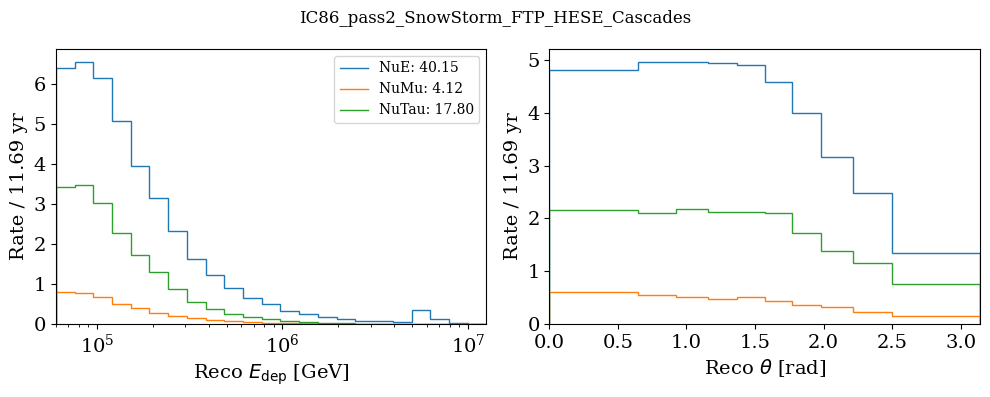

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


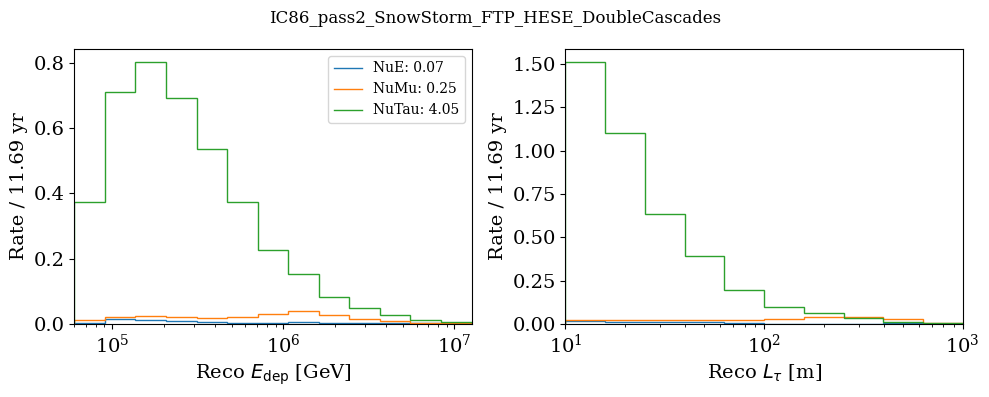

IC86_pass2_SnowStorm_FTP_HESE_Tracks


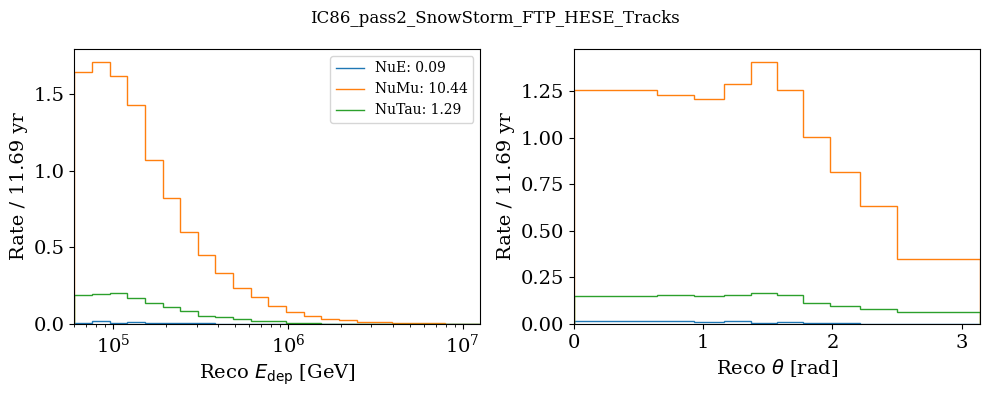

In [69]:
from plot_utils import *
for det_config in detector_configs: 
    plot_histogram_astro_flavor(hist_graph_hdl=hist_graph_hdl, det_config=det_config, ylog=None, 
                                gamma_astro = 2.87, astro_norm = 2.1233,
                                savepath=f"{plotting_path_histogram}/flavor_astro_{det_config}_ylog-None.png")

Now lets do the bdt prod

In [70]:
config_hdl = AnalysisConfig.from_configs(
        main_config_file=f"{configs_dir}/main.cfg",
        analysis_config_file = f"{configs_dir}/analysis_configs/asimov/SAY/asimov_SAY_HESEBestfit.yaml",
        config_dir=configs_dir,
        override_dict=None,
        override_config_files=["override/systematics/NoSystematics.cfg", "override/datasets_hese/mcd-simpletopology_flux-hese_feat-11features_plus_rloglmilli_econf_evtgen/bdt1_0.3_bdt2_0.4_length_10.cfg", "override/binning/hese/10bdtprod_threshold_0.12.cfg"],
        override_components_files=None,
        override_parameters_files=None)
# build a histogram
hist_graph_hdl = HistogramGraph(config_hdl)
detector_configs = config_hdl.get_det_configs()

In [71]:
plotting_path_histogram = f"{plotting_path}/11features_plus_rloglmilli_econf_evtgen/bdt1_0.3_bdt2_0.4_length_10"
os.system(f"mkdir -p {plotting_path_histogram}")

0

IC86_pass2_SnowStorm_FTP_HESE_Cascades


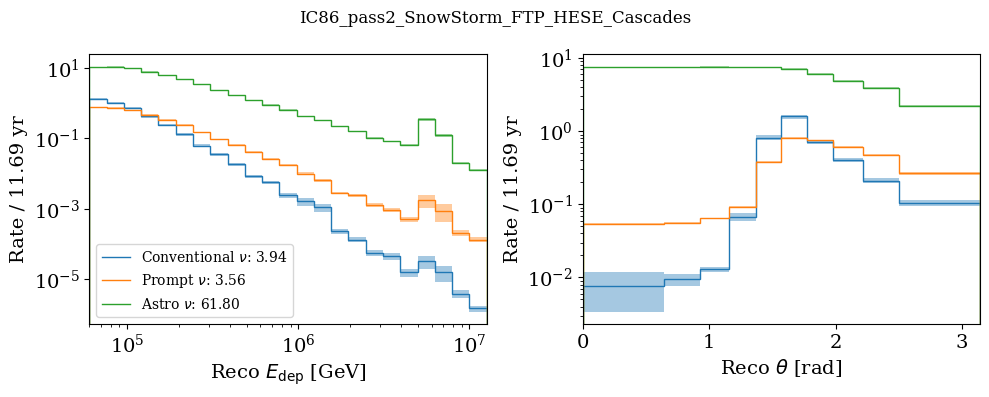

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


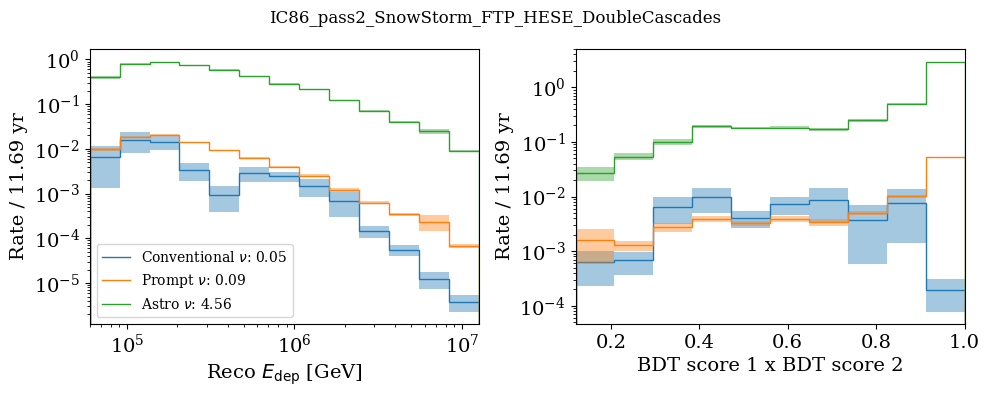

IC86_pass2_SnowStorm_FTP_HESE_Tracks


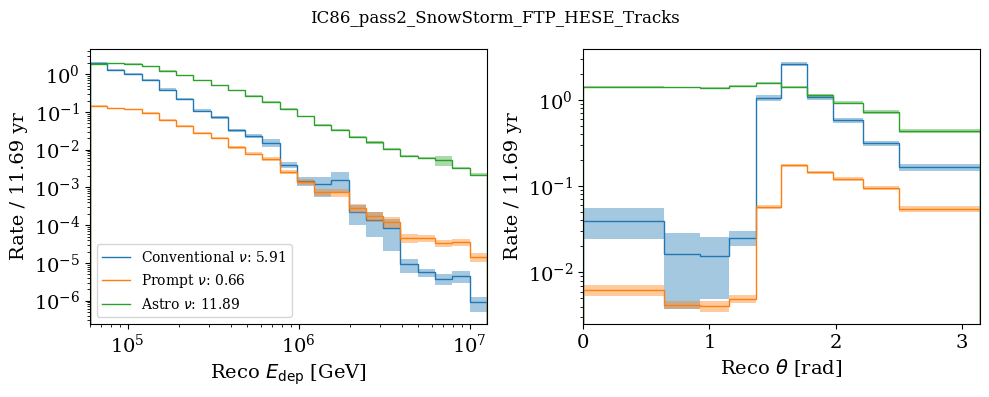

In [72]:
input_variables = {
    r"Conventional $\nu$" : {"astro_norm" : 0, "prompt_norm" : 0, "conv_norm" : 1},
    r"Prompt $\nu$" : {"astro_norm" : 0, "prompt_norm" : 1, "conv_norm" : 0},
    r"Astro $\nu$" : {"astro_norm" : 2.1233, "prompt_norm" : 0, "conv_norm" : 0},
}
for det_config in detector_configs: 
    plot_histogram(hist_graph_hdl=hist_graph_hdl, det_config=det_config, input_variables = input_variables, ylog=True, 
                   savepath=f"{plotting_path_histogram}/{det_config}_ylog-True.png")

IC86_pass2_SnowStorm_FTP_HESE_Cascades


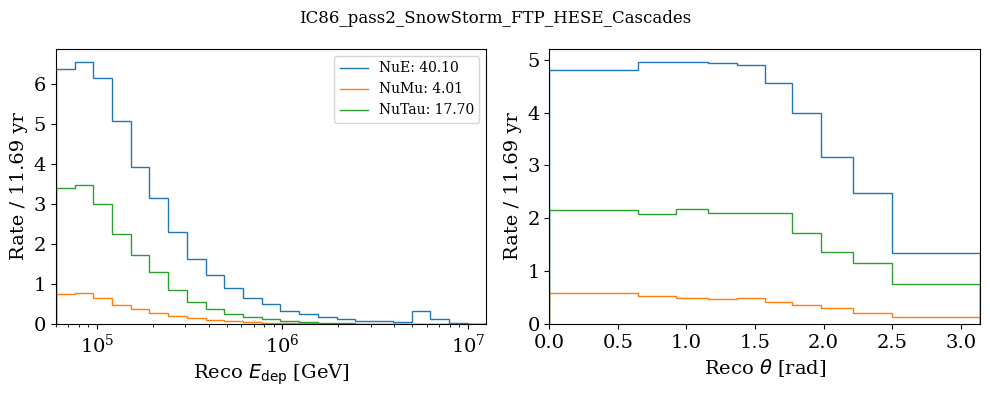

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


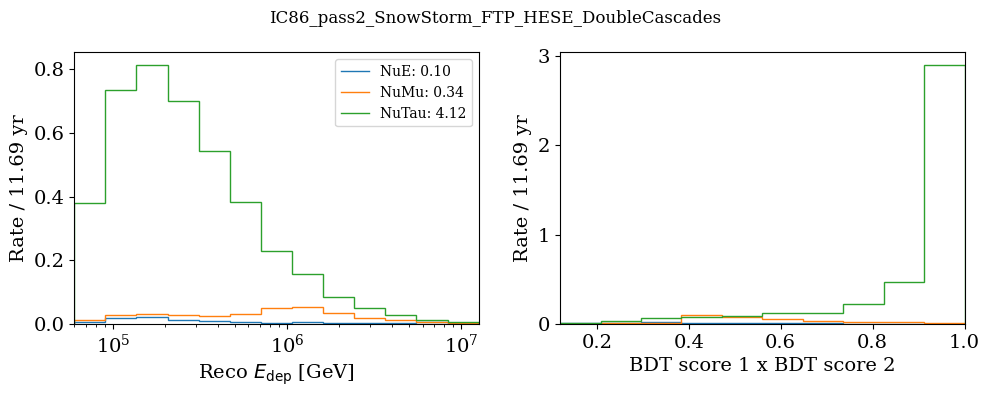

IC86_pass2_SnowStorm_FTP_HESE_Tracks


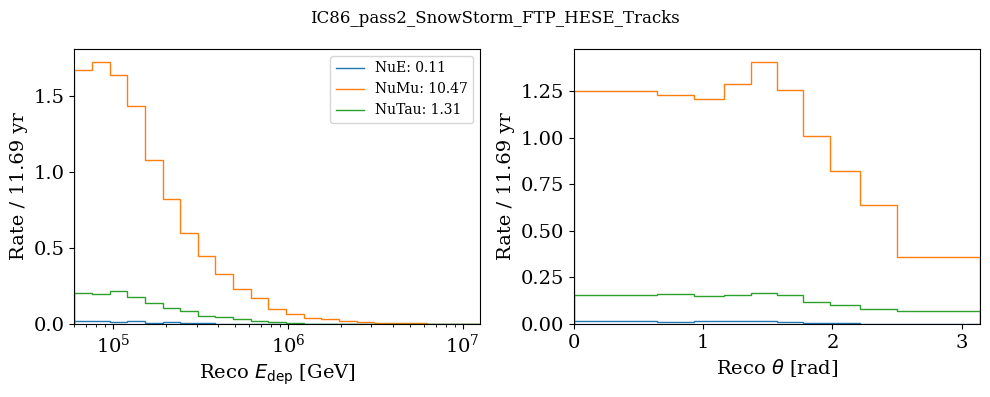

In [73]:
from plot_utils import *
for det_config in detector_configs: 
    plot_histogram_astro_flavor(hist_graph_hdl=hist_graph_hdl, det_config=det_config, ylog=None, 
                                gamma_astro = 2.87, astro_norm = 2.1233,
                                savepath=f"{plotting_path_histogram}/flavor_astro_{det_config}_ylog-None.png")

Now lets do spice!

In [74]:
config_hdl = AnalysisConfig.from_configs(
        main_config_file=f"{configs_dir}/main.cfg",
        analysis_config_file = f"{configs_dir}/analysis_configs/asimov/SAY/asimov_SAY_HESEBestfit.yaml",
        config_dir=configs_dir,
        override_dict=None,
        override_config_files=["override/systematics/NoSystematics.cfg", "override/datasets_hese/spice.cfg"],
        override_components_files=None,
        override_parameters_files=None)
# build a histogram
hist_graph_hdl = HistogramGraph(config_hdl)
detector_configs = config_hdl.get_det_configs()

In [75]:
plotting_path_histogram = f"{plotting_path}/spice"
os.system(f"mkdir -p {plotting_path_histogram}")

0

IC86_pass2_SnowStorm_FTP_HESE_Cascades


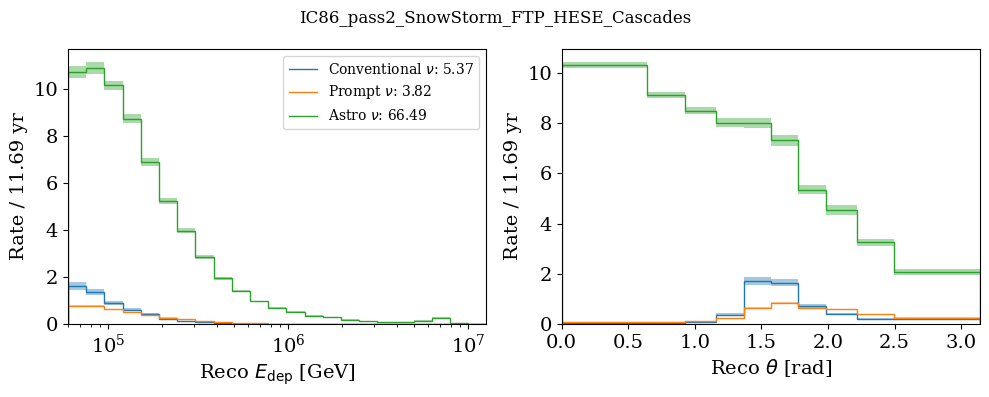

IC86_pass2_SnowStorm_FTP_HESE_Cascades


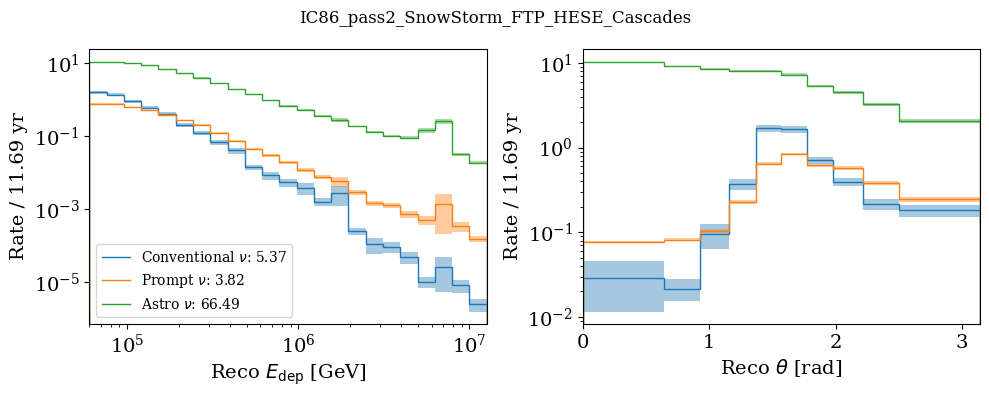

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


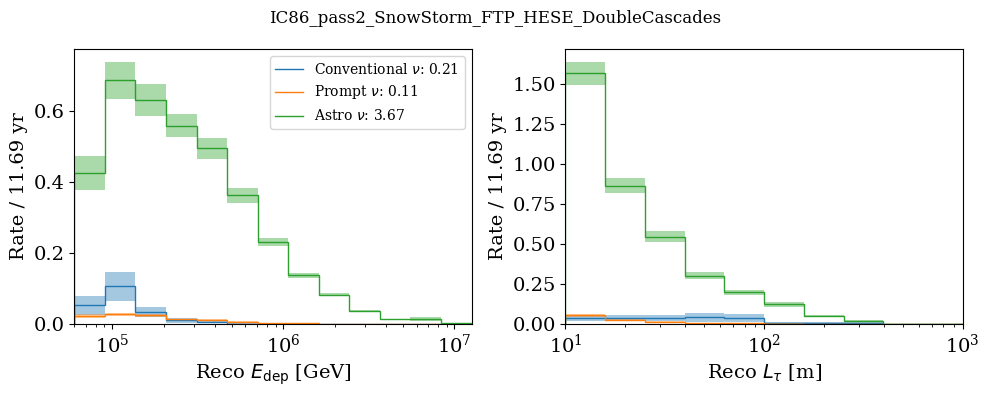

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


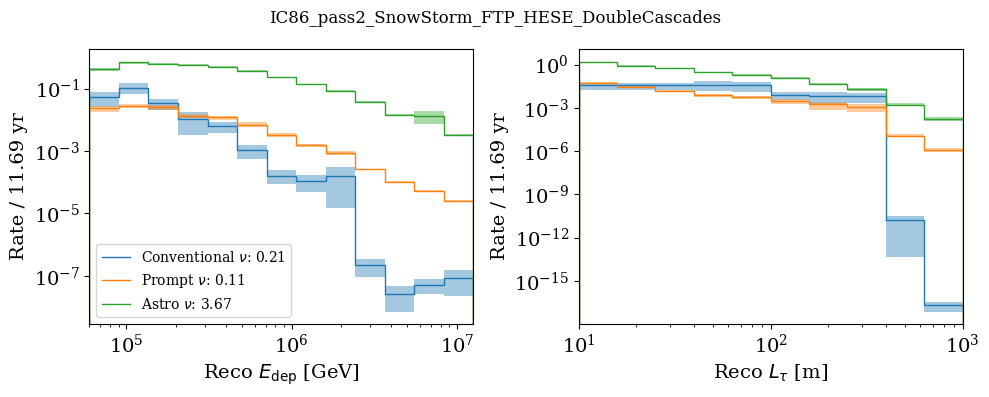

IC86_pass2_SnowStorm_FTP_HESE_Tracks


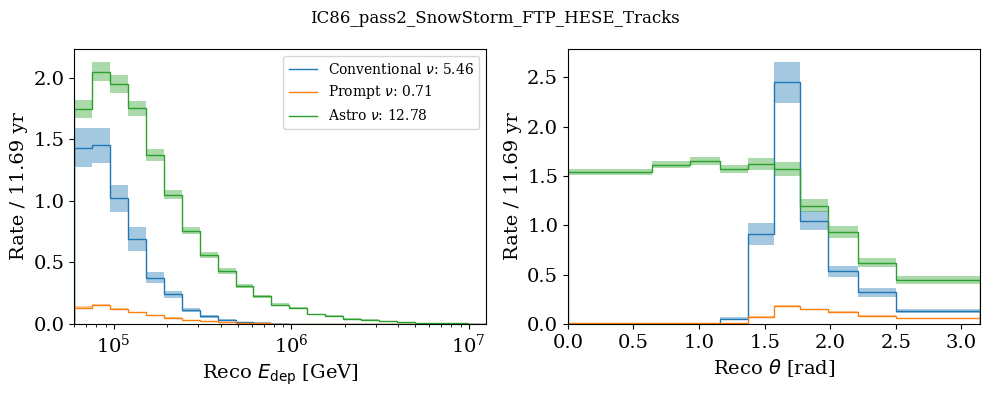

IC86_pass2_SnowStorm_FTP_HESE_Tracks


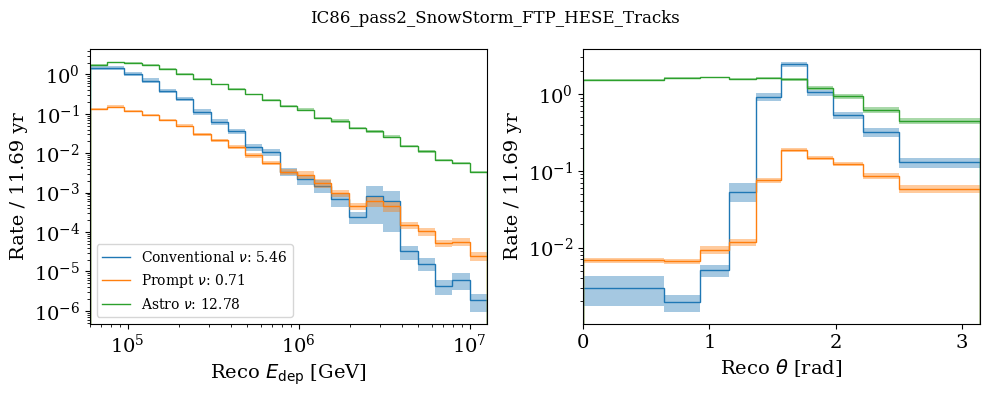

In [77]:
for det_config in detector_configs: 
    plot_histogram(hist_graph_hdl=hist_graph_hdl, det_config=det_config, input_variables = input_variables, ylog=None, 
                   savepath=f"{plotting_path_histogram}/{det_config}_ylog-None.png")
    plot_histogram(hist_graph_hdl=hist_graph_hdl, det_config=det_config, input_variables = input_variables, ylog=True, 
                   savepath=f"{plotting_path_histogram}/{det_config}_ylog-True.png")

IC86_pass2_SnowStorm_FTP_HESE_Cascades


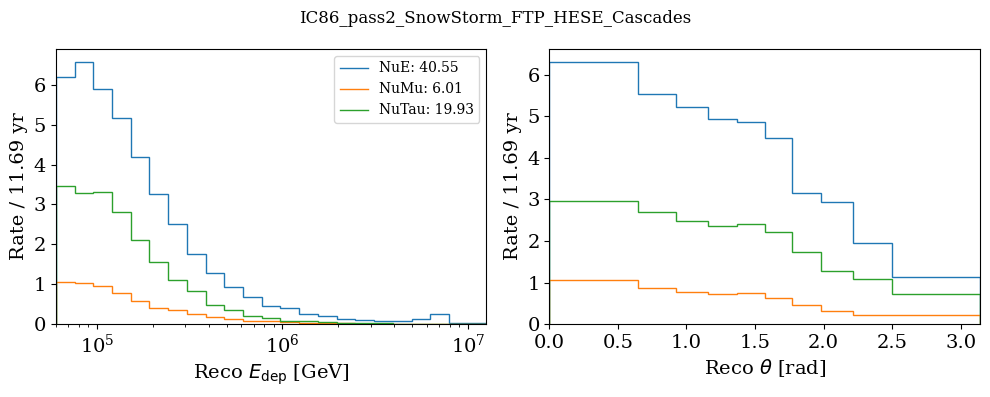

IC86_pass2_SnowStorm_FTP_HESE_DoubleCascades


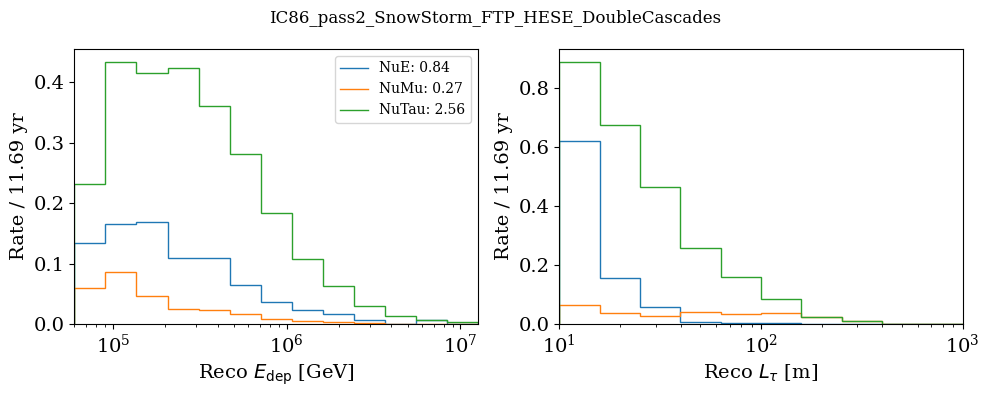

IC86_pass2_SnowStorm_FTP_HESE_Tracks


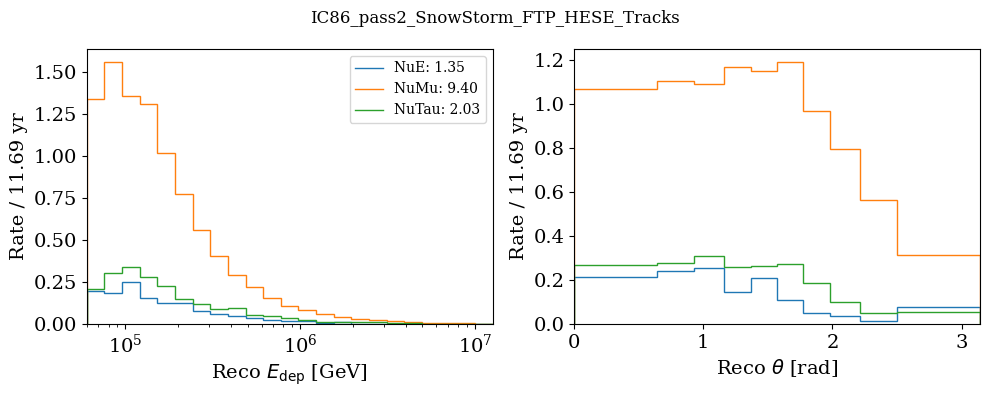

In [78]:
for det_config in detector_configs: 
    plot_histogram_astro_flavor(hist_graph_hdl=hist_graph_hdl, det_config=det_config, ylog=None, 
                                gamma_astro = 2.87, astro_norm = 2.1233,
                                savepath=f"{plotting_path_histogram}/flavor_astro_{det_config}_ylog-None.png")